In [1]:
# For input/output
from pathlib import Path
import importlib
# For numerical methods
import numpy as np

# For image processing and visualization of results
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import ConnectionPatch
import secrets
import rerun as rr
from uuid import uuid4
# For optimization with symforce
import symforce
symforce.set_epsilon_to_symbol()
import symforce.symbolic as sf
from symforce.values import Values
from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer
from symforce.opt.noise_models import BarronNoiseModel
import sym

In [2]:
import sfm
importlib.reload(sfm)

<module 'sfm' from '/Users/manavvora/Desktop/AE598_3DV/ae598-3dv/project/sfm.py'>

In [3]:
import os

In [4]:
images_dir = 'images'
image_paths = os.listdir(images_dir)
image_paths.sort()
# image_paths

image_paths = [os.path.join(images_dir, image_path) for image_path in image_paths]

In [5]:
image_paths

['images_3/20210407T033312S583_map_iofL2b.png',
 'images_3/20210407T033318S125_map_iofL2v.png',
 'images_3/20210407T033324S220_map_iofL2w.png',
 'images_3/20210407T033329S319_map_iofL2x.png',
 'images_3/20210407T033338S478_map_iofL2b.png',
 'images_3/20210407T033344S085_map_iofL2v.png',
 'images_3/20210407T033350S132_map_iofL2w.png',
 'images_3/20210407T033355S789_map_iofL2x.png',
 'images_3/20210407T033404S923_map_iofL2b.png',
 'images_3/20210407T033411S069_map_iofL2v.png',
 'images_3/20210407T033416S107_map_iofL2w.png',
 'images_3/20210407T033422S225_map_iofL2x.png']

In [6]:
images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY) for path in image_paths]

In [7]:
# When matching (max threshold for ratio test)
matching_threshold = 0.4

# When deciding if triangulated points are invalid
max_reprojection_err = 0.9

# Camera matrix
K = np.array([
    [1565.7702703272157, 0.0, 964.2389356041999],
    [0.0, 1562.3561924508267, 537.4247202074102],
    [0.0, 0.0, 1.0],
])
# K = np.array([
#     [19230.76923076923, 0.0, 512.0],
#     [0.0, 14705.882352941177, 512.0],
#     [0.0, 0.0, 1.0],
# ])

# K = np.array([
#     [14705.882352941177, 0.0, 512.0],
#     [0.0, 19230.76923076923, 512.0],
#     [0.0, 0.0, 1.0],
# ])

In [8]:
seed = secrets.randbits(32)
print(f'seeding RNG with {seed}')
rng = np.random.default_rng(seed)

seeding RNG with 670156703


In [9]:
# Create recording with unique ID
rr.init('my_sfm', recording_id=uuid4(), spawn=True)

# Initialize a time sequence
rr.set_time_seconds('stable_time', 0)

# Make view coordinates consistent with camera frames (z forward, x right, y down)
rr.log('/results', rr.ViewCoordinates.RDF, timeless=True)

In [10]:
views = []
for i in range(len(images)):
    views.append({
        'frame_id': i,
        'img': images[i],
        'R_inB_ofA': None,
        'p_inB_ofA': None,
    })


Detection

In [11]:
# Create a SIFT feature detector
sift = cv2.SIFT_create()

# Apply detector to find keypoints (pts) and descriptors (desc) in each image
for view in views:
    pts, desc = sift.detectAndCompute(image=view['img'], mask=None)
    view['pts'] = [
        {
            'pt2d': np.array(pt.pt),
            'track': None,
        }
        for pt in pts
    ]
    view['desc'] = desc

## Initialize with two-view reconstruction

### Get initial guess

Apply matcher.

In [12]:
matches = sfm.get_good_matches(views[0]['desc'], views[1]['desc'], threshold=matching_threshold)
print(f'found {len(matches)} good matches')

found 2403 good matches


Store results.

In [13]:
tracks = []
for match in matches:
    track = {
        'p_inA': None,
        'valid': True,
        'matches': [
            {'view_id': 0, 'feature_id': match.queryIdx},
            {'view_id': 1, 'feature_id': match.trainIdx},
        ]
    }
    tracks.append(track)
    views[0]['pts'][match.queryIdx]['track'] = track
    views[1]['pts'][match.trainIdx]['track'] = track

Get image coordinates of matches.

In [14]:
# Create a, b
a = []
b = []
for m in matches:
    a.append(views[0]['pts'][m.queryIdx]['pt2d'])
    b.append(views[1]['pts'][m.trainIdx]['pt2d'])
a = np.array(a)
b = np.array(b)

Visualize all good matches.

Len of a: 2403
Len of b: 2403


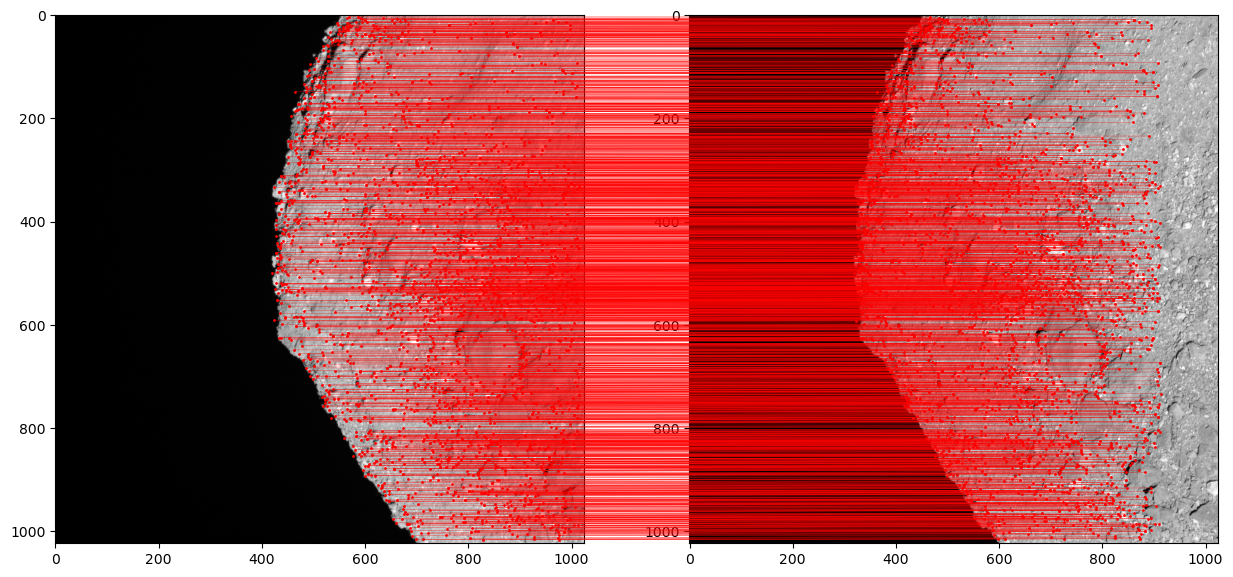

In [15]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Show images
ax1.imshow(views[0]['img'], cmap='gray')
ax2.imshow(views[1]['img'], cmap='gray')
print(f'Len of a: {len(a)}')
print(f'Len of b: {len(b)}')
# Show matches
for a_i, b_i in zip(a, b):
    fig.add_artist(
        ConnectionPatch(
            a_i, b_i, 
            'data', 'data',
            axesA=ax1, axesB=ax2,\
            color='red',
            connectionstyle='arc3, rad=0.',
            linewidth=0.2,
        )
    )
    # - Draw red dot at each keypoint
    ax1.plot(a_i[0], a_i[1], 'r.', markersize=2)
    ax2.plot(b_i[0], b_i[1], 'r.', markersize=2)

plt.show()

Do reconstruction.

In [16]:
E, num_inliers, mask = sfm.getE(a, b, K, rng, threshold=1e-3, num_iters=1000)
print(f'found {num_inliers} inliers')

# Decompose essential matrix to estimate pose and to triangulate points
R_inB_ofA, p_inB_ofA, p_inA = sfm.decomposeE(a, b, K, E)

found 2402 inliers
Candidate 2 is the most consistent


Store results.

In [17]:
# Store pose estimates
views[0]['R_inB_ofA'] = np.eye(3)
views[0]['p_inB_ofA'] = np.zeros(3)
views[1]['R_inB_ofA'] = R_inB_ofA
views[1]['p_inB_ofA'] = p_inB_ofA

# Always make sure zipped lists are the same length
assert(len(tracks) == len(p_inA))

# Store the position of the point corresponding to each track
for track, p_inA_i in zip(tracks, p_inA):
    track['p_inA'] = p_inA_i

Show results

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[    0.9979    -0.0014     0.0652    -0.0004]
                             [    0.0013     1.0000     0.0015    -0.0349]
                             [   -0.0652    -0.0014     0.9979    -0.9994]]

REPROJECTION ERRORS
 Image  0 ( 2403 points) : (mean, std, max, min) = (  0.29,   1.10,  43.58,   0.00)
 Image  1 ( 2403 points) : (mean, std, max, min) = (  0.27,   0.80,  29.21,   0.00)


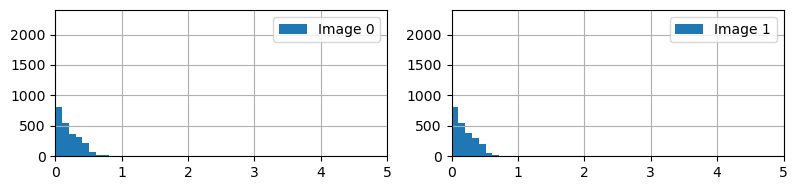

In [18]:
sfm.show_results(views, tracks, K)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_1_ini, tracks_1_ini)
```

In [19]:
views_1_ini, tracks_1_ini = sfm.copy_results(views, tracks)

### Optimize

Create initial values, factors, and optimized keys.

In [20]:
optimizer, initial_values = sfm.get_optimizer(views, tracks, K)

Iterate over 12 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 2403 tracks:
 track 0:
  track_0_p_inA has an initial value and is an optimized key
  track_0_b_0 has an initial value and an sf_projection_residual factor
  track_0_b_1 has an initial value and an sf_projection_residual factor

 ...

 track 2402:
  track_2402_p_inA has an initial value and is an optimized key
  track_2402_b_0 has an initial value and an sf_projection_residual factor
  track_2402_b_1 has an initial value and an sf_projection_residual factor


Create and run optimizer.

In [21]:
result = optimizer.optimize(initial_values)
assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)

[2024-04-29 11:23:22.387] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 3.262e+02/0.000e+00/3.034e+02, rel reduction: 6.99350e-02
[2024-04-29 11:23:24.820] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 3.034e+02/0.000e+00/2.653e+02, rel reduction: 1.25550e-01
[2024-04-29 11:23:27.028] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 2.653e+02/0.000e+00/2.414e+02, rel reduction: 9.03713e-02
[2024-04-29 11:23:29.268] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 2.414e+02/0.000e+00/2.317e+02, rel reduction: 3.98976e-02
[2024-04-29 11:23:31.463] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 2.317e+02/0.000e+00/2.048e+02, rel reduction: 1.16019e-01
[2024-04-29 11:23:33.654] [info] LM<sym::Optimize> [iter    5] lambda: 1.000e-05, error prev/linear/new: 2.048e+02/0.000e+00/1.680e+02, rel reduction: 1.79738e-01
[2024-04-29 11:23:35.8

Store results from optimization (note that this modifies `views` and `tracks` in place).

In [22]:
sfm.store_results(views, tracks, K, result, max_reprojection_err=max_reprojection_err)

     2 views with updated pose estimate
  2377 valid tracks with updated position estimate
     0 already invalid tracks
    26 newly invalid tracks


Show results.

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[    0.9978    -0.0009     0.0656    -0.0581]
                             [    0.0008     1.0000     0.0014    -0.0438]
                             [   -0.0657    -0.0013     0.9978    -0.9954]]

REPROJECTION ERRORS
 Image  0 ( 2377 points) : (mean, std, max, min) = (  0.07,   0.07,   0.73,   0.00)
 Image  1 ( 2377 points) : (mean, std, max, min) = (  0.07,   0.07,   0.73,   0.00)


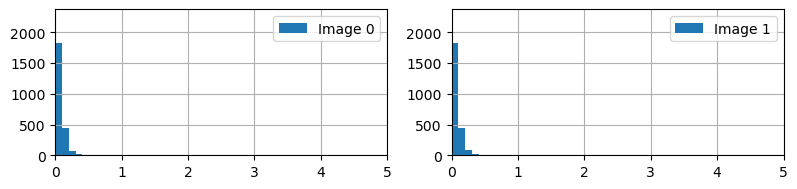

In [23]:
sfm.show_results(views, tracks, K)

Add visualization of results to the 3D viewer.

In [24]:
frames_per_second = 30
sfm.visualize_results(views, tracks, K, frames_per_second)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_1_opt, tracks_1_opt)
```

In [25]:
views_1_opt, tracks_1_opt = sfm.copy_results(views, tracks)

## Add more images

### We perform the following steps for each new image:
1. **Get initial guess**: Match new images with old images, updating views and tracks.
2. **Get data for resectioning and triangulation**: 
    Look for tracks that...
    * are valid
    * have a match with `view_id` that is the same as the new view
    * have `p_inA` that is not `None`
3. **Resection**: The output of this process is an estimate of the pose $R^C_A, p^C_A$.
    * **Visualize** the image coordinates of points on which PnP will be based.
    * **Solve** the PnP problem to estimate relative pose.
    * **Store** the results.
4. **Triangulate**: 
    * **Apply** code to triangulate and store results.
    * **Show** results.
5. **Optimize**:
    * **Create** initial values, factors and optimized keys.
    * **Create** and run optimizer.
    * **Store** the optimized results.
    * **Show** the optimized results.
6. **Visualization with Rerun**: Visualize the optimized points in 3D using rerun.
    

ADDING VIEW 2

matching image 0 with image 2 with threshold 0.4:
 2253 good matches found
  865 tracks created
    0 tracks in C extended with point in B
 1388 tracks in B extended with point in C
    0 tracks merged (trivial)
    0 tracks merged (non-trivial)
    0 inconsistent tracks

matching image 1 with image 2 with threshold 0.4:
 3339 good matches found
       trivial merge - ( 1, 2247) ( 2, 2328) - ( 0, 2061) ( 1, 2247) ( 2, 2328) 
       trivial merge - ( 1,  627) ( 2,  660) - ( 0,  576) ( 1,  627) ( 2,  660) 
       trivial merge - ( 1,  604) ( 2,  636) - ( 0,  551) ( 1,  604) ( 2,  636) 
       trivial merge - ( 1,  990) ( 2, 1067) - ( 0,  898) ( 1,  990) ( 2, 1067) 
       trivial merge - ( 1, 2509) ( 2, 2583) - ( 0, 2281) ( 1, 2509) ( 2, 2583) 
       trivial merge - ( 1, 1076) ( 2, 1158) - ( 0,  970) ( 1, 1076) ( 2, 1158) 
       trivial merge - ( 1,  134) ( 2,  140) - ( 0,  127) ( 1,  134) ( 2,  140) 
       trivial merge - ( 1, 1766) ( 2, 1882) - ( 0, 1625) ( 1, 1766) (

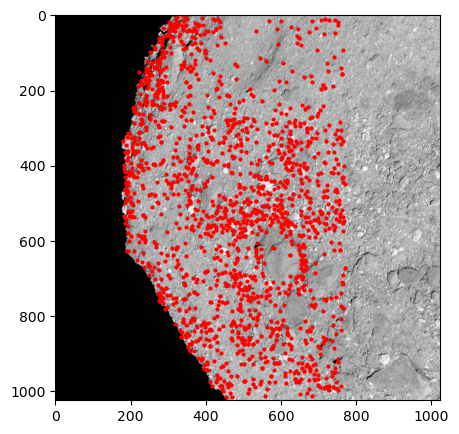

Mask:[False, False, False, False, False, False, True, False, False, False, False, False, True, True, False, False, False, False, True, True, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, True, False, True, True, True, True, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, True, True, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, True, False, False, False, False, 

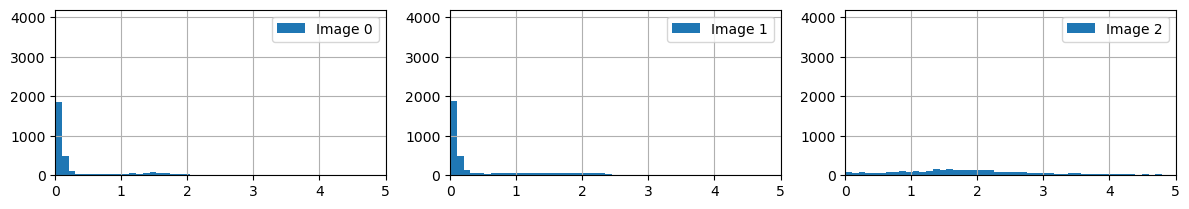

Iterate over 12 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
 T_inB2_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 4927 tracks:
 track 0:
  track_0_p_inA has an initial value and is an optimized key
  track_0_b_0 has an initial value and an sf_projection_residual factor
  track_0_b_1 has an initial value and an sf_projection_residual factor
  track_0_b_2 has an initial value and an sf_projection_residual factor

 ...

 track 4926:
  track_4926_p_inA has an initial value and is an optimized key
  track_4926_b_1 has an initial value and an sf_projection_residual factor
  track_4926_b_2 has an initial value and an sf_projection_residual factor
[2024-04-29 11:24:45.094] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 7.060e+03/0.000e+00/6.147e+03, rel reduction: 1.29370e-01
[2024-04-29 11:24:57.458] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e

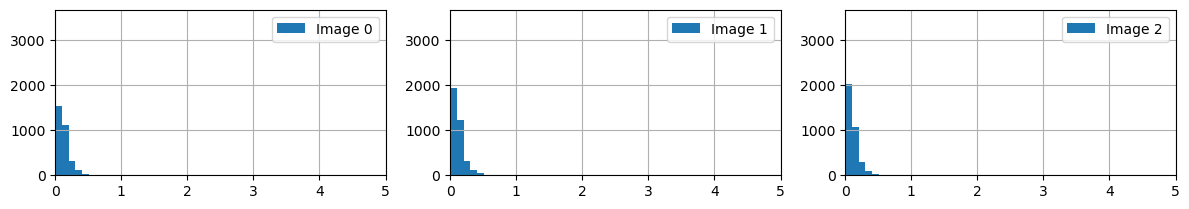

ADDING VIEW 3

matching image 0 with image 3 with threshold 0.4:
 2331 good matches found
  511 tracks created
    0 tracks in C extended with point in B
 1820 tracks in B extended with point in C
    0 tracks merged (trivial)
    0 tracks merged (non-trivial)
    0 inconsistent tracks

matching image 1 with image 3 with threshold 0.4:
 3623 good matches found
       trivial merge - ( 1, 1483) ( 3, 1646) - ( 0, 1352) ( 1, 1483) ( 2, 1586) ( 3, 1646) 
       FOUND INCONSISTENT - ( 0,  319) ( 1,  336) ( 2,  378) ( 3,  331) ( 1,  321) 
       trivial merge - ( 1, 1753) ( 3, 1936) - ( 0, 1607) ( 1, 1753) ( 2, 1865) ( 3, 1936) 
       trivial merge - ( 1, 1424) ( 3, 1554) - ( 0, 1305) ( 1, 1424) ( 2, 1515) ( 3, 1554) 
       trivial merge - ( 1, 6196) ( 3, 6739) - ( 0, 5778) ( 1, 6196) ( 2, 6343) ( 3, 6739) 
       trivial merge - ( 1, 6252) ( 3, 6787) - ( 0, 5827) ( 1, 6252) ( 2, 6400) ( 3, 6787) 
       trivial merge - ( 1,  853) ( 3,  943) - ( 0,  783) ( 1,  853) ( 2,  922) ( 3,  943) 
 

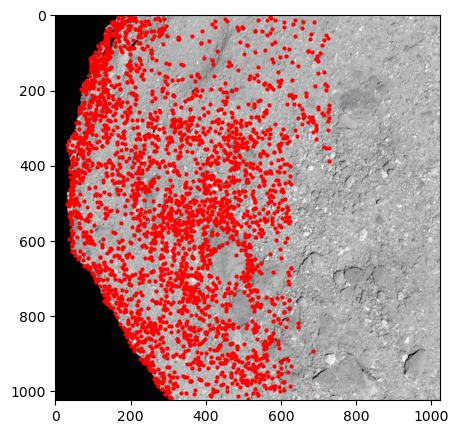

Mask:[False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, True, False, True, False, False, True, False, False, True, False, True, True, True, False, False, True, False, True, True, True, False, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, True, False, True, False, False, True, False, False, False, False, True, True, False, False, True, False, False, False, False, False, False, False, False, False, True, False, True, False, True, False, False, True, True, False, True, False, False, False, False, False, False, False, F

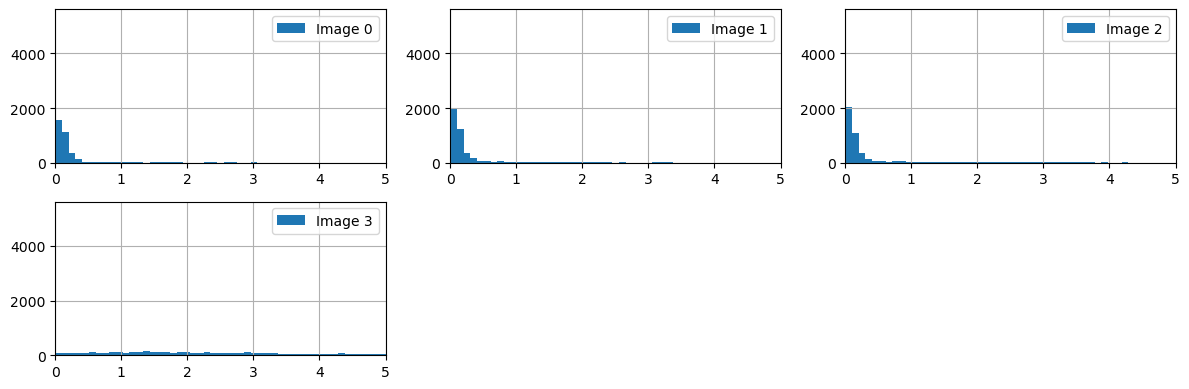

Iterate over 12 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
 T_inB2_ofA has an initial value and is an optimized key
 T_inB3_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 7621 tracks:

 ...

 track 7620:
  track_7620_p_inA has an initial value and is an optimized key
  track_7620_b_2 has an initial value and an sf_projection_residual factor
  track_7620_b_3 has an initial value and an sf_projection_residual factor
[2024-04-29 11:29:18.522] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 9.494e+03/0.000e+00/8.670e+03, rel reduction: 8.67224e-02
[2024-04-29 11:29:51.488] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 8.670e+03/0.000e+00/7.589e+03, rel reduction: 1.24738e-01
[2024-04-29 11:30:30.372] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 7.589e+03/0.000e+00/7.128e+03, rel redu

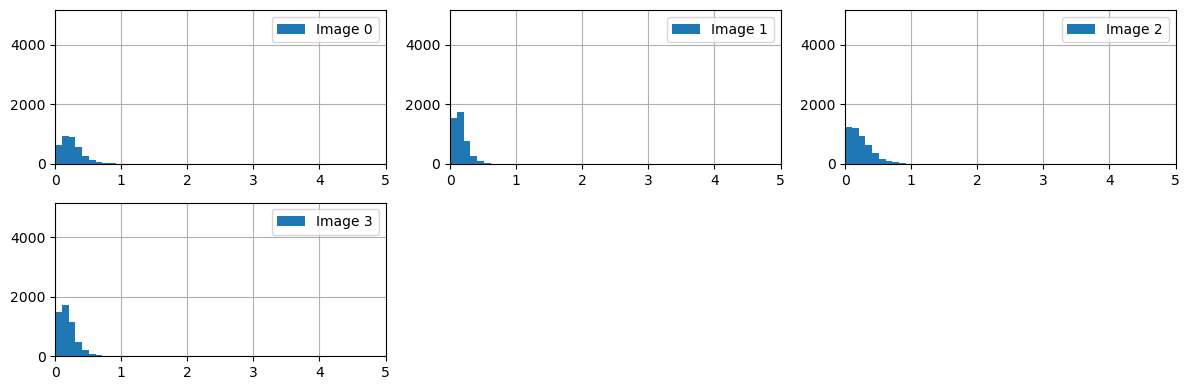

ADDING VIEW 4

matching image 0 with image 4 with threshold 0.4:
 1840 good matches found
  547 tracks created
    0 tracks in C extended with point in B
 1293 tracks in B extended with point in C
    0 tracks merged (trivial)
    0 tracks merged (non-trivial)
    0 inconsistent tracks

matching image 1 with image 4 with threshold 0.4:
 1465 good matches found
       trivial merge - ( 1, 5656) ( 4, 3920) - ( 0, 5296) ( 1, 5656) ( 2, 5829) ( 3, 6157) ( 4, 3920) 
       trivial merge - ( 1, 5646) ( 4, 3908) - ( 0, 5290) ( 1, 5646) ( 2, 5818) ( 3, 6147) ( 4, 3908) 
       trivial merge - ( 1, 6021) ( 4, 4391) - ( 0, 5638) ( 1, 6021) ( 2, 6198) ( 3, 6566) ( 4, 4391) 
       trivial merge - ( 1, 6012) ( 4, 4377) - ( 0, 5625) ( 1, 6012) ( 3, 6553) ( 4, 4377) 
       trivial merge - ( 1, 4277) ( 4, 2155) - ( 0, 3947) ( 1, 4277) ( 2, 4436) ( 3, 4680) ( 4, 2155) 
       trivial merge - ( 1, 4482) ( 4, 2407) - ( 0, 4157) ( 1, 4482) ( 3, 4903) ( 4, 2407) 
       trivial merge - ( 1, 6013) ( 4, 43

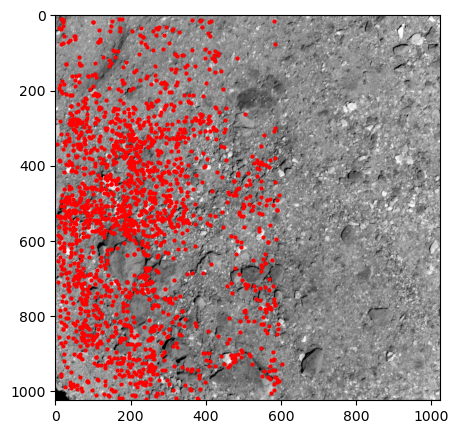

Mask:[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 

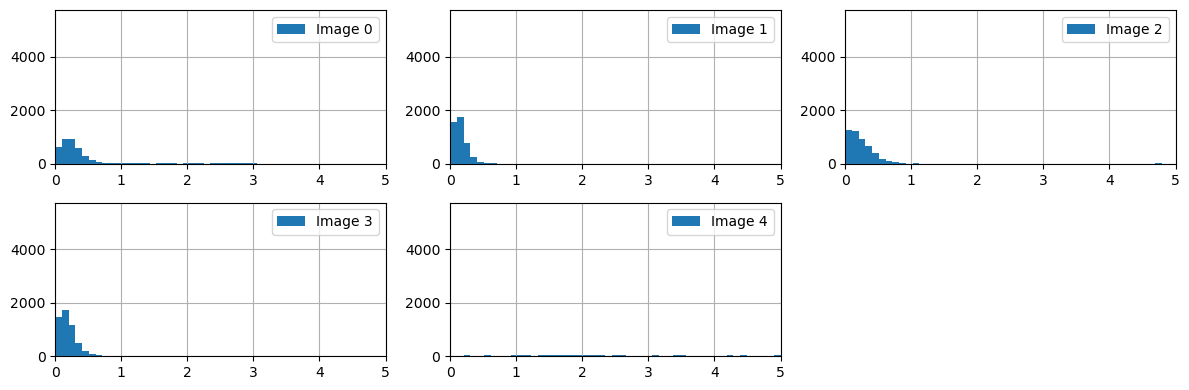

Iterate over 12 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
 T_inB2_ofA has an initial value and is an optimized key
 T_inB3_ofA has an initial value and is an optimized key
 T_inB4_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 9257 tracks:

 ...

 track 9256:
  track_9256_p_inA has an initial value and is an optimized key
  track_9256_b_3 has an initial value and an sf_projection_residual factor
  track_9256_b_4 has an initial value and an sf_projection_residual factor
[2024-04-29 11:43:53.041] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 8.037e+03/0.000e+00/7.919e+03, rel reduction: 1.47197e-02
[2024-04-29 11:44:39.147] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 7.919e+03/0.000e+00/7.451e+03, rel reduction: 5.91683e-02
[2024-04-29 11:45:26.288] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error

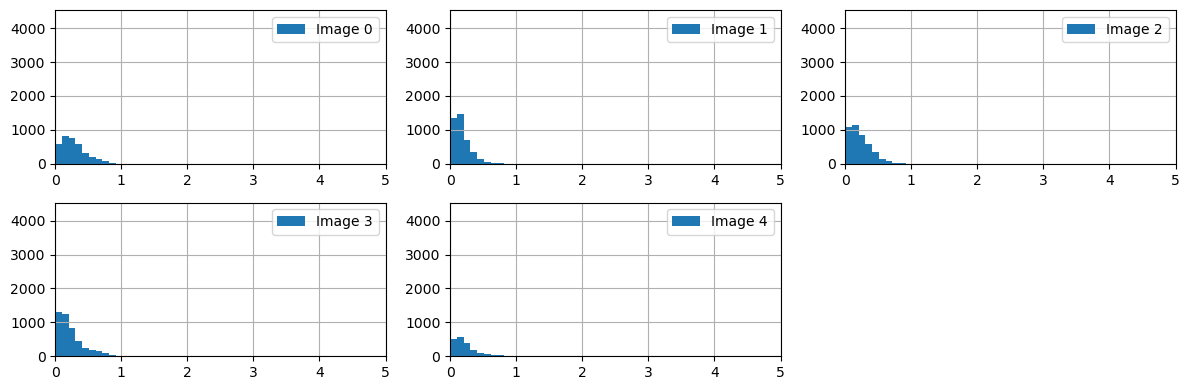

ADDING VIEW 5

matching image 0 with image 5 with threshold 0.4:
  821 good matches found
   97 tracks created
    0 tracks in C extended with point in B
  724 tracks in B extended with point in C
    0 tracks merged (trivial)
    0 tracks merged (non-trivial)
    0 inconsistent tracks

matching image 1 with image 5 with threshold 0.4:
 1434 good matches found
       trivial merge - ( 1, 5927) ( 5, 1730) - ( 0, 5551) ( 1, 5927) ( 4, 4265) ( 5, 1730) 
       trivial merge - ( 1, 4981) ( 5,  525) - ( 0, 4641) ( 1, 4981) ( 3, 5440) ( 4, 3026) ( 5,  525) 
       trivial merge - ( 1, 6021) ( 5, 1868) - ( 0, 5638) ( 1, 6021) ( 2, 6198) ( 3, 6566) ( 4, 4391) ( 5, 1868) 
       trivial merge - ( 1, 4980) ( 5,  524) - ( 0, 4640) ( 1, 4980) ( 2, 5143) ( 3, 5439) ( 4, 3025) ( 5,  524) 
       trivial merge - ( 1, 5274) ( 5,  910) - ( 0, 4914) ( 1, 5274) ( 3, 5749) ( 5,  910) 
       trivial merge - ( 1, 6208) ( 5, 2083) - ( 0, 5787) ( 1, 6208) ( 4, 4578) ( 5, 2083) 
       trivial merge - ( 1, 49

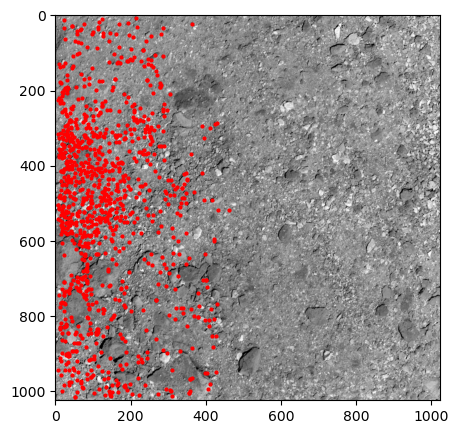

Mask:[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 

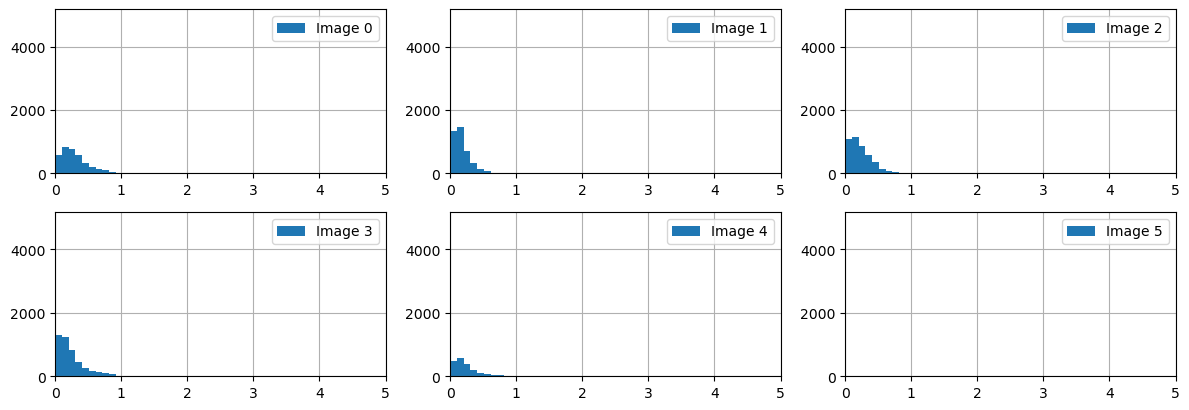

Iterate over 12 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
 T_inB2_ofA has an initial value and is an optimized key
 T_inB3_ofA has an initial value and is an optimized key
 T_inB4_ofA has an initial value and is an optimized key
 T_inB5_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 12912 tracks:

 ...

 track 12911:
  track_12911_p_inA has an initial value and is an optimized key
  track_12911_b_4 has an initial value and an sf_projection_residual factor
  track_12911_b_5 has an initial value and an sf_projection_residual factor
[2024-04-29 12:55:58.695] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1.660e+04/0.000e+00/1.644e+04, rel reduction: 9.68397e-03
[2024-04-29 12:57:13.619] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 1.644e+04/0.000e+00/1.592e+04, rel reduction: 3.17164e-02
[2024-04-29 12:58:28.054]

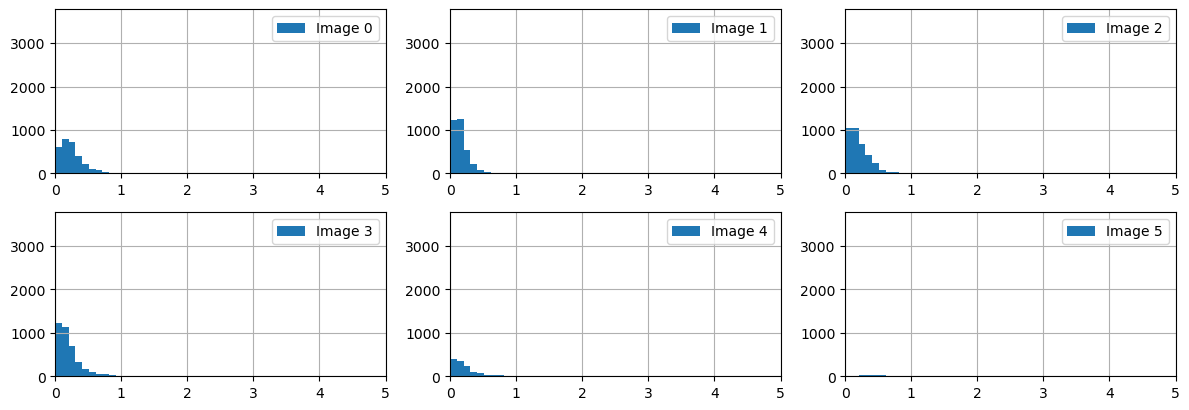

ADDING VIEW 6

matching image 0 with image 6 with threshold 0.4:
    7 good matches found
    0 tracks created
    0 tracks in C extended with point in B
    7 tracks in B extended with point in C
    0 tracks merged (trivial)
    0 tracks merged (non-trivial)
    0 inconsistent tracks

matching image 1 with image 6 with threshold 0.4:
  461 good matches found
       trivial merge - ( 1, 6966) ( 6,   79) - ( 0, 6520) ( 2, 7097) ( 1, 6966) ( 3, 7551) ( 4, 5547) ( 5, 3022) ( 6,   79) 
       FOUND INCONSISTENT - ( 1, 7197) ( 3, 7794) ( 2, 7335) ( 4, 5815) ( 5, 3325) ( 2, 7337) ( 6,  388) 
   58 tracks created
    0 tracks in C extended with point in B
  402 tracks in B extended with point in C
    1 tracks merged (trivial)
    1 tracks merged (non-trivial)
    1 inconsistent tracks

matching image 2 with image 6 with threshold 0.4:
 1021 good matches found
       trivial merge - ( 2, 7691) ( 6,  866) - ( 1, 7547) ( 2, 7691) ( 3, 8168) ( 4, 6225) ( 5, 3767) ( 6,  866) 
       trivial merg

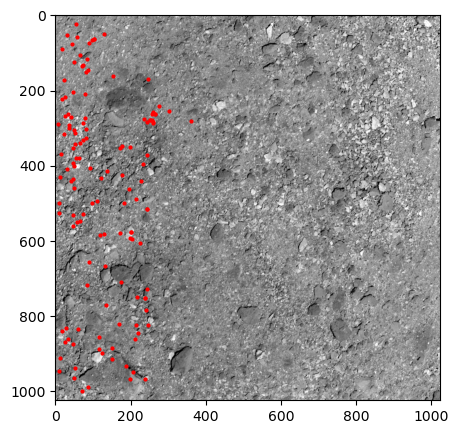

Mask:[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
found 1 inliers out of 133
POSE ESTIMATES
 [R_inA_ofB0, p_inA_of

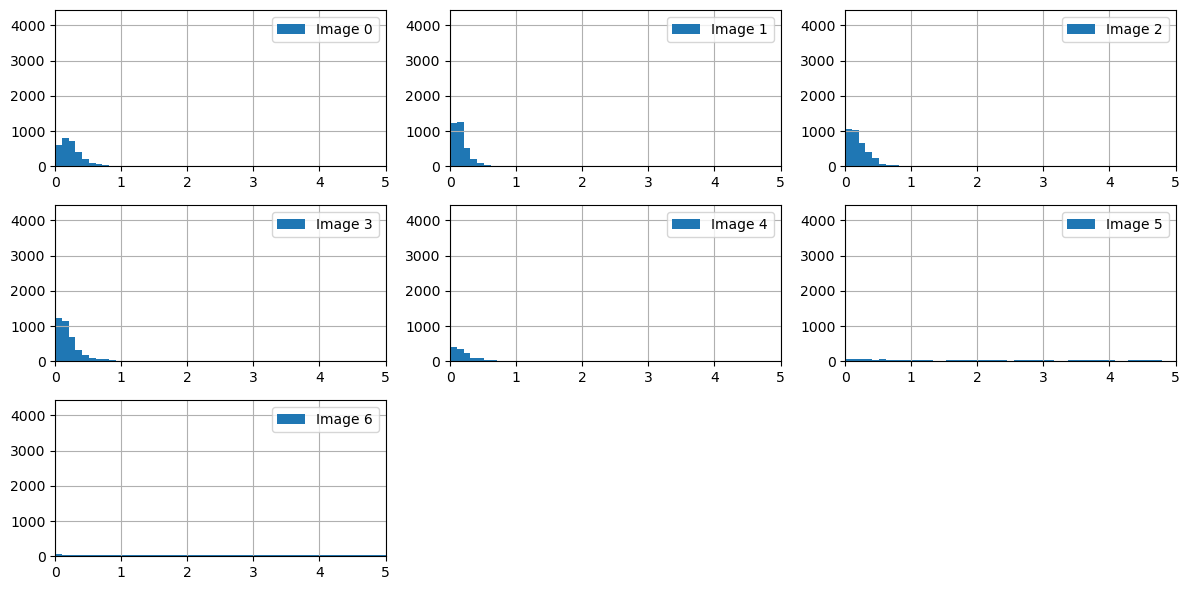

Iterate over 12 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
 T_inB2_ofA has an initial value and is an optimized key
 T_inB3_ofA has an initial value and is an optimized key
 T_inB4_ofA has an initial value and is an optimized key
 T_inB5_ofA has an initial value and is an optimized key
 T_inB6_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 17197 tracks:

 ...

 track 17196:
  track_17196_p_inA has an initial value and is an optimized key
  track_17196_b_5 has an initial value and an sf_projection_residual factor
  track_17196_b_6 has an initial value and an sf_projection_residual factor
[2024-04-29 13:39:12.373] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1.454e+04/0.000e+00/1.430e+04, rel reduction: 1.68496e-02
[2024-04-29 13:40:13.278] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 1.430e+04/0.000e+00/1.336e

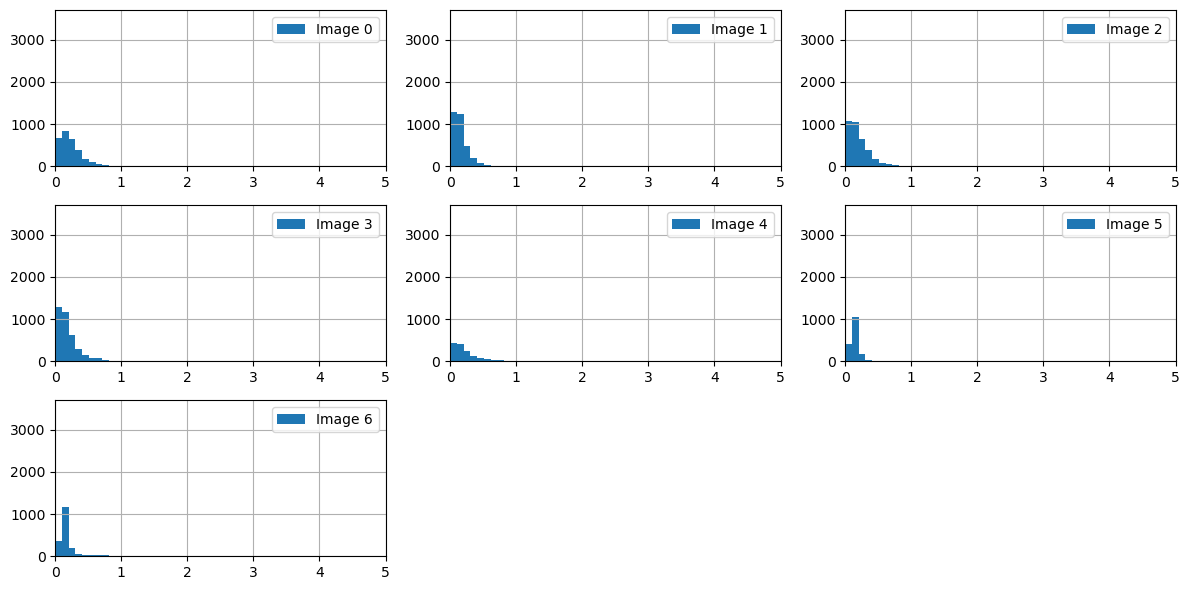

ADDING VIEW 7

matching image 0 with image 7 with threshold 0.4:
    0 good matches found
    0 tracks created
    0 tracks in C extended with point in B
    0 tracks in B extended with point in C
    0 tracks merged (trivial)
    0 tracks merged (non-trivial)
    0 inconsistent tracks

matching image 1 with image 7 with threshold 0.4:
    0 good matches found
    0 tracks created
    0 tracks in C extended with point in B
    0 tracks in B extended with point in C
    0 tracks merged (trivial)
    0 tracks merged (non-trivial)
    0 inconsistent tracks

matching image 2 with image 7 with threshold 0.4:
  326 good matches found
   61 tracks created
    0 tracks in C extended with point in B
  265 tracks in B extended with point in C
    0 tracks merged (trivial)
    0 tracks merged (non-trivial)
    0 inconsistent tracks

matching image 3 with image 7 with threshold 0.4:
  939 good matches found
       trivial merge - ( 3, 9986) ( 7,  365) - ( 2, 9459) ( 3, 9986) ( 4, 8627) ( 5, 6174) 

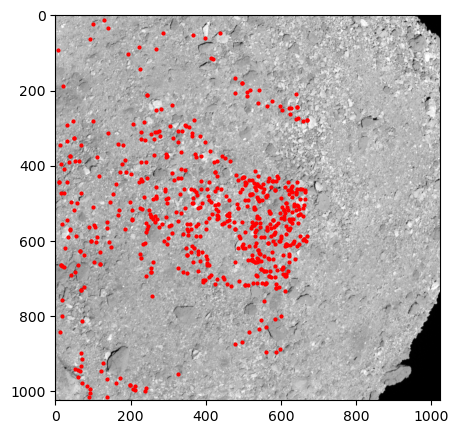

Mask:[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, True, False, False, True, False, False, False, False, False, False, True, False, True, False, False, False, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, True, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False

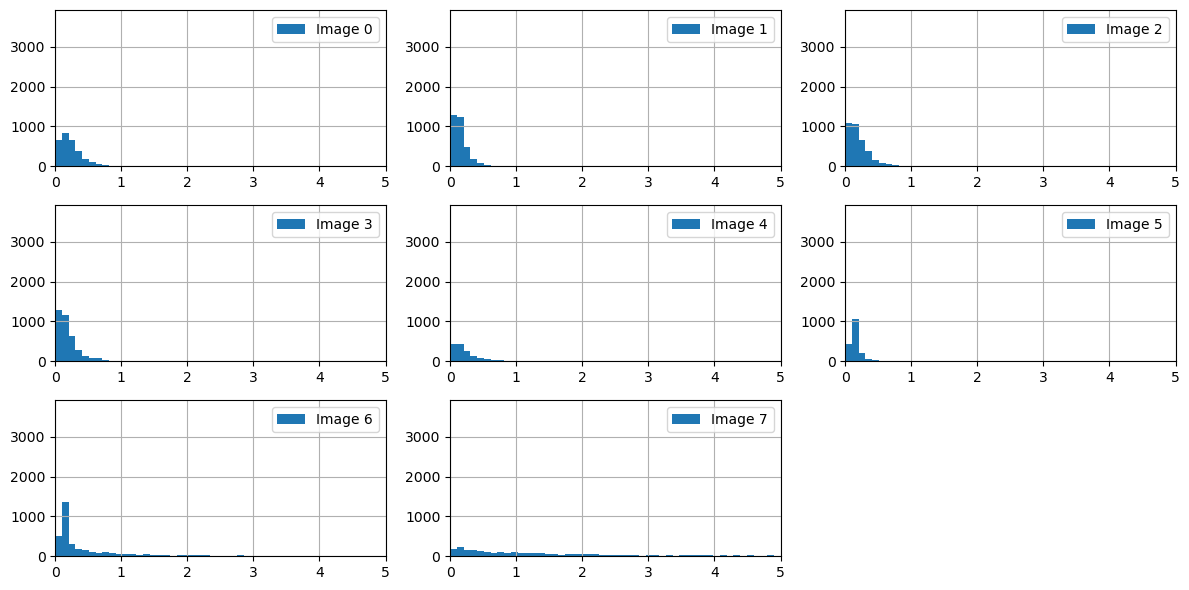

Iterate over 12 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
 T_inB2_ofA has an initial value and is an optimized key
 T_inB3_ofA has an initial value and is an optimized key
 T_inB4_ofA has an initial value and is an optimized key
 T_inB5_ofA has an initial value and is an optimized key
 T_inB6_ofA has an initial value and is an optimized key
 T_inB7_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 20076 tracks:

 ...

 track 20075:
  track_20075_p_inA has an initial value and is an optimized key
  track_20075_b_6 has an initial value and an sf_projection_residual factor
  track_20075_b_7 has an initial value and an sf_projection_residual factor
[2024-04-29 15:22:19.672] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 6.109e+03/0.000e+00/5.975e+03, rel reduction: 2.19674e-02
[2024-04-29 15:23:27.679] [info] LM<sym::Optimize> [iter    1] lambda: 1.0

AssertionError: 

[2024-04-29T22:29:41Z INFO  re_viewer::app] File saved to "/Users/manavvora/Desktop/AE598_3DV/ae598-3dv/project/latest_run_results.rrd".


In [26]:
images_to_add = 10 # Number of images to add out of the 9 remaining images/views
for i in range(images_to_add):
    # Add new image
    iC = sfm.add_next_view(views, tracks, K, matching_threshold=matching_threshold)

    # Get tracks to resection and triangulate
    tracks_to_resection = []
    tracks_to_triangulate = []
    for track in tracks:
        if not track['valid']:
            continue
        
        match = sfm.get_match_with_view_id(track['matches'], iC)
        if match is None:
            continue

        if track['p_inA'] is None:
            tracks_to_triangulate.append(track)
        else:
            tracks_to_resection.append(track)

    print(f'{len(tracks_to_resection)} tracks to resection')
    print(f'{len(tracks_to_triangulate)} tracks to triangulate')

    ## Resection
    # Visualize image coordinates of points on which PnP will be based
    p_inA = []
    c = []
    for track in tracks_to_resection:
        assert(track['p_inA'] is not None)
        p_inA.append(track['p_inA'])
        match = sfm.get_match_with_view_id(track['matches'], iC)
        c.append(sfm.get_pt2d_from_match(views, match))
    p_inA = np.array(p_inA)
    c = np.array(c)

    print(f'len(p_inA) = {len(p_inA)}, len(c) = {len(c)}')
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Show image
    ax.imshow(views[iC]['img'], cmap='gray')

    # Show matches corresponding to points that have already been triangulated
    ax.plot(c[:, 0], c[:, 1], 'r.', markersize=4)

    # Show plot    
    plt.show()
    
    # Solve the PnP problem
    R_inC_ofA, p_inC_ofA, num_inliers, mask = sfm.resection(
        p_inA,
        c,
        K,
        rng,
        threshold=2.,
        num_iters=1000,
    )
    print(f"Mask:{mask}")
    print(f'found {num_inliers} inliers out of {len(mask)}')

    #Store results
    views[iC]['R_inB_ofA'] = R_inC_ofA
    views[iC]['p_inB_ofA'] = p_inC_ofA    

    #Triangulate points
    for track in tracks_to_triangulate:
        p_inA = sfm.triangulate(track, views, K)
        track['p_inA'] = p_inA

    #Show results
    sfm.show_results(views, tracks, K)

    # Optimize---Create initial values, factors and optimized keys
    optimizer, initial_values = sfm.get_optimizer(views, tracks, K)

    # Optimize---Create and run optimizer
    result = optimizer.optimize(initial_values)
    assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)

    # Optimize---Store results
    sfm.store_results(views, tracks, K, result, max_reprojection_err=max_reprojection_err)

    # Optimize---Show results
    sfm.show_results(views, tracks, K)

    # Optimize---Visualize results
    sfm.visualize_results(views, tracks, K, frames_per_second)

# Copy the final results---can be used as initial values when adding more images
views_opt_final, tracks_opt_final = sfm.copy_results(views, tracks)